# To-Do
- ~~rerun flows from 1981 as start date~~
- ~~cast features as category dtype before training catboost~~
- ~~engineer categorical features from 'number_of_outings_in_last_year' and 'trip_fishing_effort_hours'~~
- ~~re-evaluate models after adding new features -> look at feature importance on catboost model~~
- ~~naive bayes outperforming catboost~~
- waterfall plot on CategoricalNB - inverse transform not working
- single observation force plot on CatBoost not working
- look at interactions on both models
- pipreqs to update requirements.txt

In [ ]:
import duckdb
import shap
import pandas as pd
from pathlib import Path
from catboost import CatBoostClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score

shap.initjs()

In [3]:
#constants
SCHEMA = 'analytics'
DUCKDB_PATH = str(Path().resolve().parent / "data/noaa_dw.duckdb")

In [4]:
#Database Connection and Query
with duckdb.connect(DUCKDB_PATH) as con:
    query = f"""
            SELECT
            fish_caught_time_of_day,
            trip_month_name,
            fishing_season,
            us_region,
            nautical_zone,
            fishing_method_collapsed,
            number_of_outings_in_last_year,
            number_of_outings_in_last_2_months,
            trip_fishing_effort_hours,
            caught
            FROM
            {SCHEMA}.trip_details
            """
    df = con.sql(query).df() #materialize into pandas dataframe

### Preprocessing

In [5]:
df = df.dropna() #drop any rows that have NaNs

In [6]:
# Feature Engineering
def get_annual_outing_frequency(number_of_annual_outings):
    if number_of_annual_outings == 0:
        return 'Rarely (First Outing)'
    elif number_of_annual_outings <= 50:
        return 'Sometimes (<= 50x/year)'
    elif number_of_annual_outings <= 100:
        return 'Often (50-100x/year)'
    else:
        return 'Very Often (> 100x/year)'

def get_bimonthly_outing_frequency(number_of_bimonthly_outings):
    if number_of_bimonthly_outings == 0:
        return 'Rarely (First Outing)'
    elif number_of_bimonthly_outings <= 5:
        return 'Sometimes (<= 5 outings)'
    elif number_of_bimonthly_outings <= 15:
        return 'Often (5-15 outings)'
    else:
        return 'Very Often (> 15 outings)'

def get_effort_rating(effort_hours):
    if effort_hours == 0:
        return 'No Effort'
    elif effort_hours <= 5:
        return 'Low (<= 5 hours)'
    elif effort_hours <= 15:
        return 'Moderate (5-15 hours)'
    else:
        return 'High (> 15 hours)'

df['annual_outing_freq'] = df['number_of_outings_in_last_year'].apply(get_annual_outing_frequency)
df['bimonthly_outing_freq'] = df['number_of_outings_in_last_2_months'].apply(get_bimonthly_outing_frequency)
df['effort_rating'] = df['trip_fishing_effort_hours'].apply(get_effort_rating)


In [51]:
def preprocess_data(df: pd.DataFrame):
    #Define Features and Label
    drop_cols = ['number_of_outings_in_last_2_months',
                'number_of_outings_in_last_year',
                'trip_fishing_effort_hours',
                'trip_month_name',
                'caught']
    X = df.drop(columns=drop_cols)
    feature_names = X.columns.tolist()
    X = X.astype('category') # cast as category dtype
    y = df['caught'].astype(int)

    return feature_names, X, y

### Baseline Model - Categorical Naive Bayes

In [52]:
#Train model and predict
feature_names, X, y = preprocess_data(df)

#Encoding
encoder = OrdinalEncoder()
X = encoder.fit_transform(X)

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CategoricalNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test) #probability estimates
print("class = ", y_pred)
print("proba = ", y_proba)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

class =  [0 0 0 ... 1 0 0]
proba =  [[0.8608634  0.1391366 ]
 [0.9300577  0.0699423 ]
 [0.8803525  0.1196475 ]
 ...
 [0.38643774 0.61356226]
 [0.80022267 0.19977733]
 [0.73371554 0.26628446]]
[[486804 120497]
 [235797 207249]]
0.6501181431045171
              precision    recall  f1-score   support

           0       0.67      0.80      0.73    607301
           1       0.63      0.47      0.54    443046

    accuracy                           0.66   1050347
   macro avg       0.65      0.63      0.63   1050347
weighted avg       0.66      0.66      0.65   1050347



### SHAP

In [53]:
sample_size = 10000
X_train_sample = shap.utils.sample(encoder.inverse_transform(X_train), sample_size)
X_test_sample = shap.utils.sample(encoder.inverse_transform(X_test), sample_size)

#Bar plot feature importance
explainer = shap.Explainer(model.predict, X_train_sample, feature_names=feature_names)
shap_values = explainer(X_test_sample)
shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[0])

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [45]:
sample_size = 100
X_train_sample = shap.utils.sample(X_train, sample_size)
X_test_sample = shap.utils.sample(X_test, sample_size)

#Force plot
explainer = shap.KernelExplainer(model.predict_proba, X_train_sample, feature_names=feature_names)
shap_values = explainer.shap_values(X_test_sample[0])
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test_sample[0])

### Alternate Model - CatBoost

In [54]:
#Train model and predict
feature_names, X, y = preprocess_data(df)

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_features = X_train.columns.tolist()
model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           cat_features=cat_features,
                           loss_function='Logloss',
                           verbose=True)

model.fit(X_train, y_train) #fit model
y_pred = model.predict(X_test) #predict
y_proba = model.predict_proba(X_test) #probability estimates
print("class = ", y_pred)
print("proba = ", y_proba)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))
print(f'Feature Importance: {dict(zip(model.feature_names_,model.get_feature_importance()))}')
print(f'{model.best_score_}')

0:	learn: 0.6267803	total: 887ms	remaining: 887ms
1:	learn: 0.6058692	total: 1.81s	remaining: 0us
class =  [0 0 0 ... 0 0 0]
proba =  [[0.76362869 0.23637131]
 [0.84133562 0.15866438]
 [0.76362869 0.23637131]
 ...
 [0.59433522 0.40566478]
 [0.76362869 0.23637131]
 [0.76362869 0.23637131]]
[[546280  61021]
 [277284 165762]]
0.650256409870547
              precision    recall  f1-score   support

           0       0.66      0.90      0.76    607301
           1       0.73      0.37      0.49    443046

    accuracy                           0.68   1050347
   macro avg       0.70      0.64      0.63   1050347
weighted avg       0.69      0.68      0.65   1050347

Feature Importance: {'fish_caught_time_of_day': 0.0, 'fishing_season': 0.0, 'us_region': 33.37228722414956, 'nautical_zone': 0.0, 'fishing_method_collapsed': 66.62771277585044, 'annual_outing_freq': 0.0, 'bimonthly_outing_freq': 0.0, 'effort_rating': 0.0}
{'learn': {'Logloss': 0.605869243719783}}


### SHAP

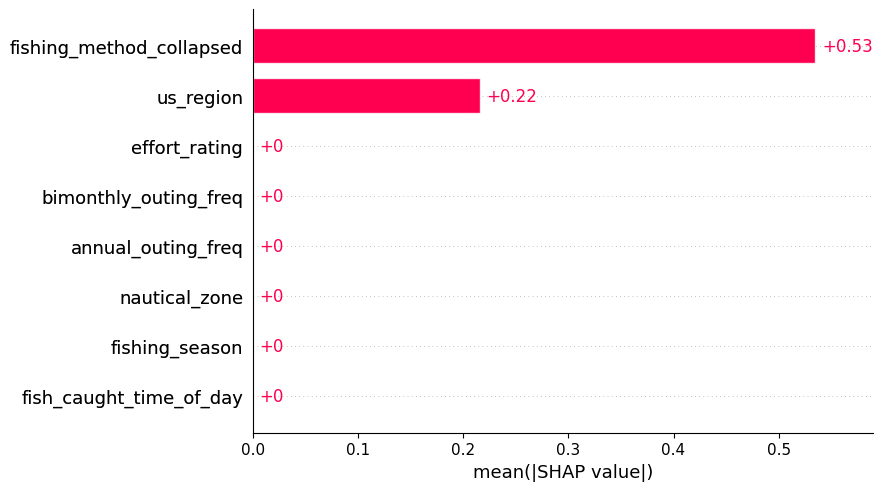

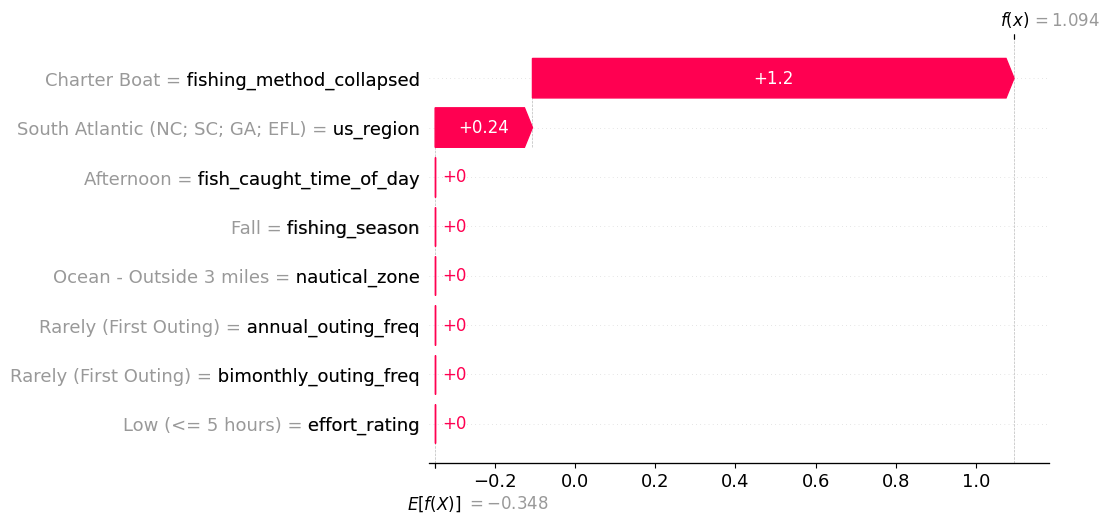

In [62]:
#Bar plot feature importance
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[3]) #expected and predicted is caught (1)

In [ ]:
sample_size = 100
X_train_sample = shap.utils.sample(X_train, sample_size)
X_test_sample = shap.utils.sample(X_test, sample_size)

#Force plot
explainer = shap.KernelExplainer(model.predict_proba, X_train_sample, feature_names=feature_names)
shap_values = explainer.shap_values(X_test_sample)
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test_sample)

KeyError: 1

In [36]:
print(X_train.shape)
print(X_test.shape)

(4201387, 8)
(1050347, 8)
